In [5]:
import SimpleITK as sitk
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from rabies.visualization import otsu_scaling, plot_3d
import nilearn.plotting
from rabies.utils import recover_3D
from rabies.analysis_pkg.diagnosis_pkg.analysis_QC import masked_plot, percent_threshold
import pandas as pd


plt.rcParams.update({
    "lines.color": "black",
    "patch.edgecolor": "black",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"})

template_file='/home/gabriel/.local/share/rabies/EPI_template.nii.gz'
scaled = otsu_scaling(template_file)


In [6]:
def plot_brainmaps(axes, mask_file, DR_file, GS_file, BOLDsd_file, DR_time_file):
    prior_bold_idx = [5, 19]
    prior_confound_idx = [0, 2, 6, 7, 8, 9, 10, 11, 13, 14, 21, 22, 24, 26, 28, 29]
    
    mask_img = sitk.ReadImage(mask_file)
    volume_indices=sitk.GetArrayFromImage(mask_img).astype(bool)    

    scaled_ = sitk.Resample(scaled,mask_img)

    ax = axes[0]

    sitk_img = sitk.ReadImage(BOLDsd_file)

    plot_3d([ax], scaled_, fig, vmin=0, vmax=1,
            cmap='gray', alpha=1, cbar=False, num_slices=4, planes=('coronal'))


    # select vmax at 95th percentile value
    vector = sitk.GetArrayFromImage(sitk_img).flatten()
    vector.sort()
    vmax = vector[int(len(vector)*0.99)]
    cbar_list = plot_3d([ax], sitk_img, fig, vmin=0, vmax=vmax,
            cmap='inferno', alpha=1, cbar=True, num_slices=4, planes=('coronal'))
    for cbar in cbar_list:
        cbar.ax.get_yaxis().labelpad = 35
        cbar.set_label('Standard \n Deviation', fontsize=17, rotation=270, color='black')
        cbar.ax.tick_params(labelsize=15)

    ax.set_title('BOLD variability', fontsize=25, color='black')



    ax = axes[1]

    plot_3d([ax], scaled_, fig, vmin=0, vmax=1,
            cmap='gray', alpha=1, cbar=False, num_slices=4, planes=('coronal'))

    sitk_img = sitk.ReadImage(GS_file)

    # select vmax at 95th percentile value
    vector = sitk.GetArrayFromImage(sitk_img).flatten()
    vector.sort()
    vmax = vector[int(len(vector)*0.99)]
    cbar_list = plot_3d([ax], sitk_img, fig, vmin=-vmax, vmax=vmax,
            cmap='cold_hot', alpha=1, cbar=True, num_slices=4, planes=('coronal'))
    for cbar in cbar_list:
        cbar.ax.get_yaxis().labelpad = 20
        cbar.set_label("Covariance", fontsize=17, rotation=270, color='black')
        cbar.ax.tick_params(labelsize=15)

    ax.set_title('Global signal covariance', fontsize=25, color='black')

    for bold_idx,network_name,ax in zip(prior_bold_idx, ['Somatomotor', 'Default mode'], [axes[2],axes[3]]):

        sitk_img = sitk.ReadImage(DR_file)[:,:,:,bold_idx]
        map = sitk.GetArrayFromImage(sitk_img)[volume_indices]

        threshold = percent_threshold(map)
        mask=np.abs(map)>=threshold # taking absolute values to include negative weights
        mask_img = recover_3D(mask_file,mask)
        sitk_img = recover_3D(
            mask_file, map)

        masked = sitk_img*mask_img
        vmax=map.max()

        plot_3d([ax],scaled_,fig,vmin=0,vmax=1,cmap='gray', alpha=1, cbar=False, num_slices=4, planes=('coronal'))
        cbar_list = plot_3d([ax],masked,fig,vmin=-vmax,vmax=vmax,cmap='cold_hot', alpha=1, cbar=True, threshold=vmax*0.001, num_slices=4, planes=('coronal'))

        for cbar in cbar_list:
            cbar.ax.get_yaxis().labelpad = 35
            cbar.set_label("Beta \nCoefficient", fontsize=17, rotation=270, color='black')
            cbar.ax.tick_params(labelsize=15)

        ax.set_title(f'Network map ({network_name})', fontsize=25, color='black')
    
    ax=axes[4]

    DR_W = np.array(pd.read_csv(DR_time_file, header=None))
    temporal_info = {}
    temporal_info['DR_bold'] = DR_W[:, prior_bold_idx]
    temporal_info['DR_confound'] = DR_W[:, prior_confound_idx]

    x = range(DR_W.shape[0])

    # we take the mean of the timecourse amplitude (absolute values) to summarized across all components
    import matplotlib.cm as cm
    Greens_colors = cm.Greens(np.linspace(0.5, 0.8, 2))
    Blues_colors = cm.Blues(np.linspace(0.5, 0.8, 2))
    Purples_colors = cm.Purples(np.linspace(0.5, 0.8, 3))
    YlOrRd_colors = cm.YlOrRd(np.linspace(0.3, 0.8, 4))
    legend=[]
    for network_time,name,color,scaler in zip(
            [temporal_info['DR_confound'], temporal_info['DR_bold']],
            ['Confounds', 'Networks'],
            [YlOrRd_colors[2], Blues_colors[1]],
            [0,-1]):
        if len(network_time)>0:
            # make sure the timecourses are normalized
            network_time = network_time.copy()
            network_time /= np.sqrt((network_time ** 2).mean(axis=0))
            network_time_avg = np.abs(network_time).mean(axis=1)
            # we introduce a scaler to prevent overlap of confound with network timecourses
            network_time_avg += scaler
            ax.plot(x,network_time_avg, color=color, alpha=0.6)
            legend.append(name)

    ax.set_title(f'Network VS Confound amplitude', fontsize=25, color='black')
    ax.legend(legend, loc='center left', fontsize=17, bbox_to_anchor=(0.7, 0.7))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Timepoint', fontsize=20)
    ax.set_ylabel('Mean amplitude \n(a.u.)', fontsize=20)
    ax.yaxis.set_ticklabels([])
    plt.setp(ax.get_xticklabels(), fontsize=17)

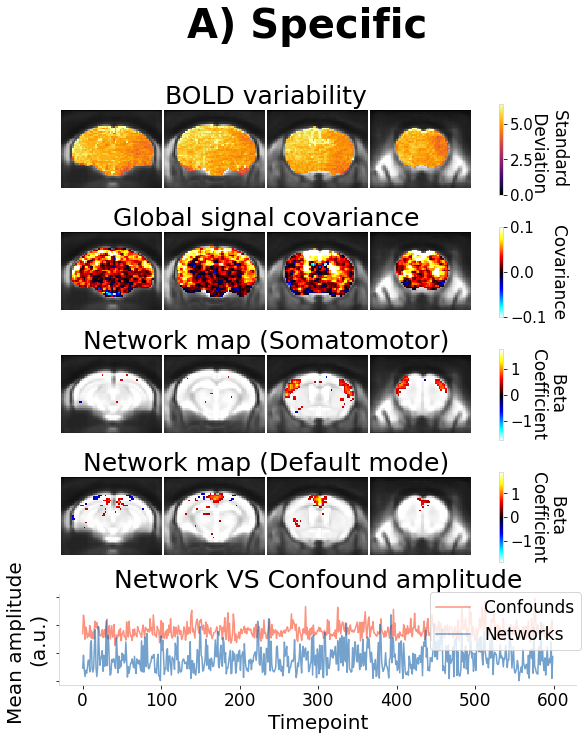

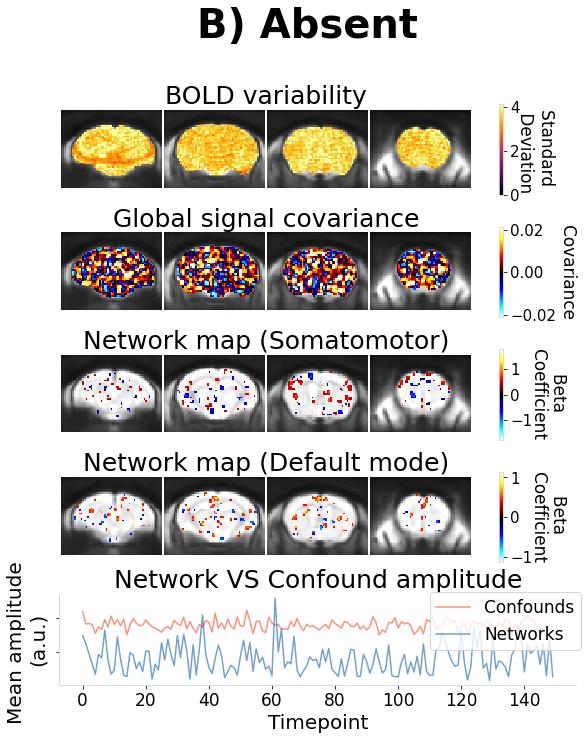

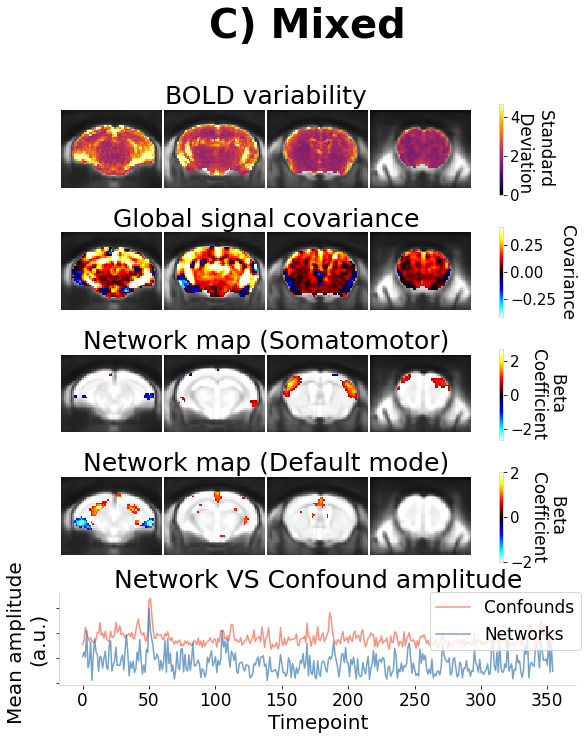

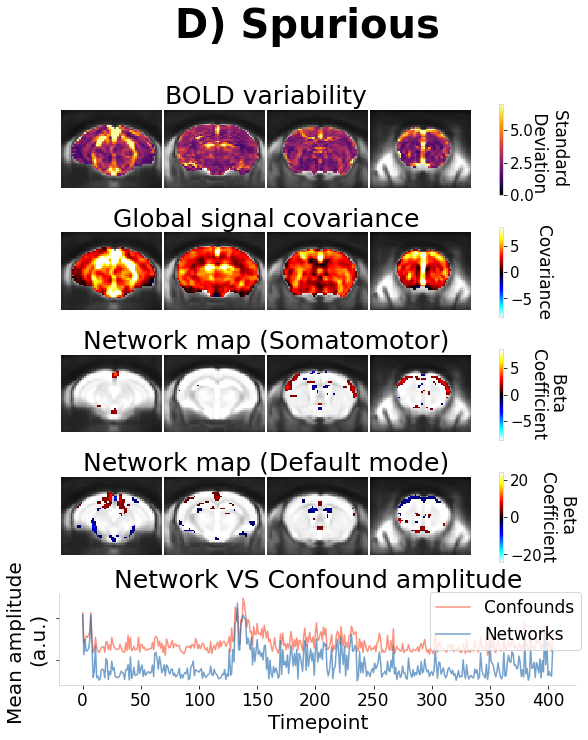

In [7]:
sub_list=['sub-092','sub-076','sub-199','sub-238']
title_list=['A) Specific\n','B) Absent\n','C) Mixed\n','D) Spurious\n']

for sub,title in zip(sub_list,title_list):
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 2*5))
    fig.suptitle(title, fontsize=40,fontweight="bold")
    plt.tight_layout()

    DR_file = f'figure_2/{sub}/{sub}_ses-1_task-rest_acq-EPI_bold_combined_cleaned_DR_maps.nii.gz'
    DR_time_file = f'figure_2/{sub}/{sub}_ses-1_task-rest_acq-EPI_bold_combined_cleaned_dual_regression_timecourse.csv'
    GS_file = f'figure_2/{sub}/{sub}_ses-1_task-rest_acq-EPI_bold_GS_cov.nii.gz'
    BOLDsd_file = f'figure_2/{sub}/{sub}_ses-1_task-rest_acq-EPI_bold_tSTD.nii.gz'
    mask_file = f'figure_2/{sub}/{sub}_ses-1_task-rest_acq-EPI_bold_EPI_brain_mask.nii.gz'
    
    plot_brainmaps(axes, mask_file, DR_file, GS_file, BOLDsd_file, DR_time_file)
    